# Rat 05 forward model with linear elasticity

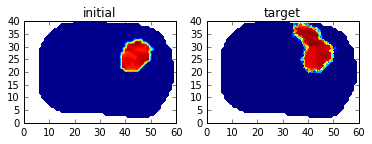

AttributeError: 'NoneType' object has no attribute 'value_size'

In [9]:
%matplotlib inline
from __future__ import print_function
from dolfin import *
from dolfin_adjoint import *
import numpy as np
import os, sys
import scipy.io as scio
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colors

set_log_level(ERROR) 

class InterpolatedParameter(Expression):
    '''
        Class to get tumor cell distributions by interpolating based off matrices of tumor cell data
    '''
    def __init__(self,X,Y,image,**kwargs):
        self.X = X # A numpy array giving the X-spacing of the image
        self.Y = Y # Same for Y
        self.image = image # The image of measured material property    
    def eval_cell(self,values,x,cell):
        interp_handle = RegularGridInterpolator((self.X,self.Y),self.image)
        values[0] = interp_handle(x)
        
def interp(file_loc,mat_name):
    mat = scio.loadmat(file_loc)[mat_name]
    mat = np.fliplr(mat.T)/np.max(mat)  # Needs to be adjusted to fit the mesh correctly
    x,y = mat.shape[0], mat.shape[1]
    mat_interp = InterpolatedParameter(np.linspace(1,x,x),np.linspace(1,y,y),mat,degree=1)
    return interpolate(mat_interp,V)

def vis_obs(initial_p,target_p,title1,title2):
    '''
        Compare two quantity plots, for example initial vs. target cellularity
        Accepts titles for each plot
    '''
    target_p = interpolate(target_p,V0)
    cm1 = colors.ListedColormap([[0,1,0,1],[0,0,0,1],[1,0,0,1]])    
    cm2 = cm.get_cmap('jet')
    plt.figure()
    plt.subplot(1,2,1)
    plt.title(title1)
    plot(initial_p,cmap=cm2)
 
    plt.subplot(1,2,2)
    plt.title(title2)
    plot(target_p,cmap=cm2)
    plt.show()

def forward(initial_p,annotate=False,record=False,record_initial=False,record_target=False):
    """ 
        Here, we define the forward problem. 
    """
    global D, gammaD
    U = VectorFunctionSpace(mesh,'Lagrange',1)
    
    def boundary(x, on_boundary):
        return on_boundary
    bc = DirichletBC(U, Constant((0.,0.)), boundary)
    
    '''
        - E(u) returns the Green-Lagrange strain tensor
        - sigma(...) returns the stress tensor based on the cells (phi), elasticity coefficients, and a coefficient beta
        - vonmises(...) calculates the von Mises stress
    '''
    def E(u):
        return 0.5*(nabla_grad(u) + nabla_grad(u).T)
    def sigma(u,phi):
        return 2*mu*(E(u)-beta*phi*Identity(2))+lam*(tr(E(u))-2*beta*phi)*Identity(2)
    def vonmises(u, phi):
        s = sigma(u, phi) - (1./3)*tr(sigma(u, phi))*Identity(2)  # deviatoric stress
        von_Mises = sqrt(3./2*inner(s, s))
        return project(von_Mises, V)
    
    k.rename('k','k field')              # field of growth rate, treated as a local parameter here
    p_n = Function(V, name = 'pn', annotate = annotate) # current distribution of cell density (phi_T)
    p_n = interpolate(initial_p,V)
    p_n.rename('phi_T','tumor fraction')
    p = Function(V, name = 'p', annotate = annotate)
    q = TestFunction(V)
    F_RD = (p - p_n)*q*dx + dt*D*dot(grad(q),grad(p))*dx - dt*k*p*(1 - p)*q*dx  
    
    u = TrialFunction(U)
    v = TestFunction(U)
    F_LE = -inner(sigma(u, p_n), E(v))*dx 
    a, L = lhs(F_LE), rhs(F_LE)
    u = Function(U, name = 'u', annotate = annotate)
    def le():
        solve(a == L, u, bc, annotate = annotate)
        return u

    # Prepare the solution
    t = 0.
    for n in range(num_steps):
        # Update current time
        t += dt
        
        # Compute solution
        solve(F_RD == 0, p, annotate = annotate) # with trivial Neumann BC

        # Update previous solution
        p_n.assign(p, annotate = annotate)
        disp = le()
        vm = vonmises(disp,p_n)
        D = D0*exp(-gammaD*vm)

    return p

# Callback function for the optimizer
# Writes intermediate results to a logfile
def eval_cb(j, m):
    """ The callback function keeping a log """
    print("objective = %15.10e " % j)

def objective(p, target_p, r_coeff1, r_coeff2):
    return assemble(inner(p-target_p, p-target_p)*dx) + r_coeff1*assemble(k*k*dx) + r_coeff2*assemble(dot(grad(k),grad(k))*dx)

def optimize(dbg=False):
    """ The optimization routine """
    # Define the control
    m = [Control(k), Control(gammaD)]
    
    # Execute first time to annotate and record the tape
    p = forward(initial_p,True)

    J = objective(p, target_p, r_coeff1, r_coeff2)

    # Prepare the reduced functional
    rf = ReducedFunctional(J,m,eval_cb_post=eval_cb)

    # Run the optimization
    m_opt = minimize(rf,method='L-BFGS-B', tol=1.0e-6,options={"disp":True,"gtol":1.0e-6})
    
    return m_opt

#########################################################################
# MAIN 
#########################################################################

case = 0
r_coeff1 = 0.01
r_coeff2 = 0.01
output_dir = './output/rat05'

# Prepare a mesh
mesh = Mesh("../rat-data/rat05/gmsh.xml")
V0 = FunctionSpace(mesh, 'DG', 0)
V = FunctionSpace(mesh, 'CG', 1)

# Load initial tumor condition data
initial_p = interp("../rat-data/rat05/ic.mat","ic")
initial_p.rename('initial','tumor at day 0')

target_p = interp("../rat-data/rat05/tumor_t2.mat","tumor")  
target_p.rename('target','tumor at day 2')

# Model parameters
T = 2.0             # final time
num_steps = 20       # number of time steps
dt = Constant(T / num_steps)   # time step size
Theta = Constant(1.0) # carrying capacity
mu, lam, beta = 1.0, .001, .001
D0 = Constant(1.)      # mobility or diffusion coefficient
D = project(D0,V)      # mobility or diffusion coefficient

# Parameters to be optimized
gammaD = Constant(1.)     # initial guess of gamma_D
k0 = Constant(1.)  # growth rate initial guess
k = project(k0,V)

vis_obs(initial_p,target_p,'initial','target') # visualize the initial and target cellularity

# Optimization module
[k, gammaD] = optimize() # optimize the k field using the adjoint method provided by adjoint_dolfin
model_p = forward(initial_p,False,True,True,True) # run the forward model using the optimized k field
print('norm(k_opt) = '+str(norm(k)))
print('J_opt = '+str(objective(model_p, target_p, r_coeff1, r_coeff2)))
print('J_opt (without regularization) = '+str(objective(model_p, target_p, 0., 0.)))
vis_obs(model_p,target_p,'model','actual')
plot(k)
